In [1]:
import sys
import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

sys.path.append(os.getcwd())
from load_data import *
from plotting_tools import *

sys.path.append('../3_score/')
from optimize import Scores
from fingerprint import FuzzyFingerPrint

In [2]:
def get_data(
        receptor,
        rmsd_file = 'xrmsd.csv',
        glide = 'xglide',
        crystal_ifp = 'ifp/crystal_ifp_3/ifp.fp',
        glide_ifp = 'ifp/xglide_ifp_3',
        w = [10,10,10,0,0]
    ):
    
    data_set_dir = '/scratch/PI/rondror/docking_data/'+receptor
    glide_dir = '{}/{}/'.format(data_set_dir, glide)
    crystal_fp_file = '{}/{}'.format(data_set_dir, crystal_ifp)
    glide_fp_dir = '{}/{}/'.format(data_set_dir, glide_ifp)
    
    return load_data(data_set_dir, rmsd_file, glide_dir, crystal_fp_file, glide_fp_dir,w)

def sort_data(d):
    crystals, glides = d
    
    ligs = sorted(glides.keys())
    if receptor == 'HSP90': ligs = hsp90_ligs(ligs)
    if receptor == 'B2AR': ligs = b2ar_ligs(ligs)
        
    structs = []
    for l in ligs:
        structs.extend([i for i in glides[l] if i not in structs])
    structs.sort()

    new_glides = {l:{s:glides[l][s] for s in glides[l] if s in structs} for l in glides if l in ligs}

    return crystals, new_glides, ligs, structs

def hsp90_ligs(all_ligs):
    return [l for l in all_ligs if l not in ['4YKY', '4YKZ', '4YKX']]

def b2ar_ligs(all_ligs):
    return [l for l in all_ligs if l not in ['3P0G']]

def print_table(a):
    str1 = '|'
    str2 = '|'
    for i in ['min','ave','norm','opt','glide','us']:
        str1 = '{} {} |'.format(str1, i)
        str2 = '{} {} |'.format(str2, str(np.mean(a[i]))[:4])
    
    print str1
    print str2
                
def analyze(scores):
    a = scores.all_analysis
    plot_score_breakdown(scores)
    plot_n_rmsds(scores)
    #plot_clusters(scores)
    for i, l in enumerate(scores.ligands):
        #if a['us'][1][i] > 2 or a['us'][1][i] > a['glide'][1][i] + 1:
        print l
        print 'Ligand {}, structure {}, has an rmsd of {}'.format(l, scores.struct, a['us'][1][i])
        s = scores.get_final_scores(l)
        print 'Glide pose: {}. Score: {}.'.format(a['glide'][0][i], s[a['glide'][0][i]])
        print 'Best pose: {}. Score: {}.'.format(a['min'][0][i], s[a['min'][0][i]])
        print 'Our pose: {}. Score: {}.'.format(a['us'][0][i], s[a['us'][0][i]])
        print 'Neighbors: <lig> [pose_num, pair_score, rmsd]'
        scores.print_neighbors(l, a['us'][0][i])
        print '----------------'
        #for j, l2 in enumerate(scores.ligands):
            #if l == l2: continue
            #plot_all_poses(l, l2, scores, '{}, {}'.format(l, l2))
        
        #plot_scores_vs_rmsds(l, scores, lab=l)
            
    #return [a['glide'][1][:] for l in range(len(scores.ligands))])

In [3]:
def plot_fp_breakdown(fp_list, label_list, title):
    bd = {label_list[i]: fp_breakdown(fp_list[i]) for i in range(len(fp_list))}
    fp_ind = np.arange(len(fp_list))
    leg = {0:'res=hdonor', 1:'res=hacc', 2:'sb', 3:'lj', 4:''}
    plt.bar(fp_ind, [bd[l][0] for l in label_list], label=leg[0])
    for i in range(1,len(bd[label_list[0]])):
        prev = [sum([bd[l][i-n-1] for n in range(i)]) for l in label_list]
        plt.bar(fp_ind, [bd[l][i] for l in label_list], bottom=prev, label=leg[i])
    plt.gca().set_xticklabels(label_list, minor=False, rotation='vertical')
    plt.gca().set_xticks(np.arange(0,len(label_list),1))
    plt.legend()
    plt.title(title)
    plt.show()
    


def plot_all_pairs(l1, l2, l3, scores):
    plot_all_poses(l1, l2, scores, l1+l2)
    plot_all_poses(l1, l3, scores, l1+l3)
    plot_all_poses(l2, l3, scores, l2+l3)

In [11]:
def mul_overlap(fp1, fp2, i=None):
    score = 0
    for r in fp1.feats:
        if r in fp2.feats:
            score += np.dot(fp1.feats[r], fp2.feats[r])
    return score

def distance(fp1, fp2, p=1):
    dist = 0
    empty = [0,0,0,0,0]
    mag1 = 0
    mag2 = 0
    #is_interaction = lambda fp, r, i: r in fp.feats and True in [fp.feats[r][j] >= 1 for j in i]
    all_r = fp1.feats.keys() + [r for r in fp2.feats if r not in fp1.feats.keys()]
    for r in all_r:#[r for r in fp1.feats if is_interaction(fp1,r,[0,1,3]) and is_interaction(fp2,r,[0,1,3])]:
        vec1 = np.square(fp1.feats.get(r,empty))
        vec2 = np.square(fp2.feats.get(r,empty))
        dist += np.linalg.norm(np.subtract(vec1, vec2),ord=p)**p
        mag1 += np.linalg.norm(vec1, ord=p)**p
        mag2 += np.linalg.norm(vec2, ord=p)**p
    return (dist/(mag1*mag2)**0.5)**(1.0/p)

def add_overlap(fp1, fp2, w=[1,1,1,1,1]):
    #new_feats = {}
    score = 0
    empty = [0,0,0,0,0]
    for r in fp1.feats.keys() + [i for i in fp2.feats if i not in fp1.feats]:
        vec1 = np.square(np.multiply(fp1.feats.get(r,empty),w))
        vec2 = np.square(np.multiply(fp2.feats.get(r,empty),w))
        score += np.sum(np.square(np.add(vec1, vec2)))
        #score += np.sum(np.square(np.add(, np.square(fp2.feats.get(r,[0,0,0,0,0])))))
    #for r in fp2.feats:
    #    if r not in fp1.feats:
    #        score += np.sum(np.square(np.square(fp2.feats[r])))
    return score

def score_fp(fp):
    return np.sum([np.sum(fp.feats[r]) for r in fp.feats])

def score_three_mul(fp1, fp2, fp3, overlap=mul_overlap):
    return score_fp(overlap(overlap(fp1, fp2), fp3))

def score_three_sum(fp1, fp2, fp3, overlap=mul_overlap):
    return overlap(fp1, fp2) + overlap(fp1, fp3) + overlap(fp2, fp3)
    #return score_fp(overlap(fp1, fp2))+score_fp(overlap(fp1, fp3))+score_fp(overlap(fp2, fp3))

def fp_breakdown(fp):
    bd = {}
    for r in fp.feats:
        for i, s in enumerate(fp.feats[r]):
            bd[i] = bd.get(i,0) + s
    return bd

In [12]:
def plot_ifp_comparison(fp1, fp2, i=[0,1,2,3], lab1='fp1', lab2='fp2', title={0:'res=hdonor',1:'res=hacc',2:'sb',3:'lj'}):
    is_interaction = lambda fp, r, i: r in fp.feats and True in [fp.feats[r][j] >= 1 for j in i]
    sort_key = lambda r: int(r)
    fp1_res = sorted([r for r in fp1.feats if is_interaction(fp1, r, i) and not is_interaction(fp2, r, i)], key=sort_key)
    both_res= sorted([r for r in fp1.feats if is_interaction(fp1, r, i) and is_interaction(fp2, r, i)], key=sort_key)
    fp2_res = sorted([r for r in fp2.feats if not is_interaction(fp1, r, i) and is_interaction(fp2, r, i)], key=sort_key)
    symb = {0:'*',1:'s',2:'d',3:'.'}
    res = fp1_res + both_res + fp2_res
    val1 = {j:[] for j in i}
    val2 = {j:[] for j in i}
    for j in i:
        for r in res:
            if is_interaction(fp1, r, [j]):
                val1[j].append(fp1.feats[r][j]**2)
            else:
                val1[j].append(-1)
            if is_interaction(fp2, r, [j]):
                val2[j].append(fp2.feats[r][j]**2)
            else:
                val2[j].append(-1)
        plt.plot(val1[j], symb[j]+'r', markersize=10, label=title[j])
        plt.plot(val2[j], symb[j]+'b', markersize=10)
    plt.legend()
    plt.title('red = {}, blue = {}'.format(lab1, lab2))
    plt.gca().set_ylim([0,12])
    plt.gca().set_xticklabels(res, minor=False, rotation='vertical')
    plt.gca().set_xticks(np.arange(0,len(res),1))
    plt.show()
    print 'Distance: {}'.format(distance(fp1, fp2, 2))

In [6]:
receptor = 'CHK1' # ['AR', 'B2AR', 'CHK1', 'CDK2']
(xcrystals, xglides, all_ligs, all_structs) = sort_data(get_data(receptor))

Loading crystal structures...
Loading glidescores...
0 of 169 total pairs failed to dock.
Loading fingerprints...
Loading docking results...


In [7]:
n = 25
best_rmsd_matrix = get_docking_stats(all_ligs, all_structs, xglides, n, lambda x: np.min(x) if x != [] else np.nan)

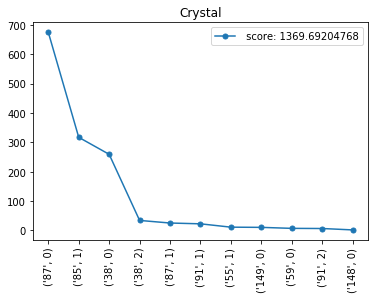

In [13]:
get_ipython().magic(u'matplotlib inline')
lig_subset = ['4FSM', '4FSN', '4FSQ','4FSR','4FSW','4FSZ','4FT0','4FT5']
struct = '4FT7'
crystal_cluster = {(l, -1):xcrystals[l].fp for l in xcrystals}#lig_subset}
plot_shared_interactions(crystal_cluster, max_r=20,title='Crystal')

In [14]:
scores = Scores(xglides, xcrystals, lig_subset, '4FT7', n, mul_overlap)

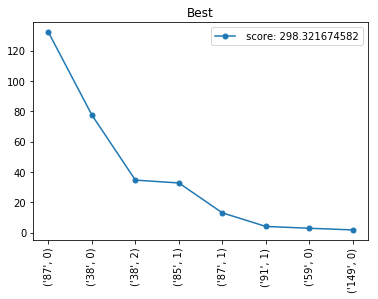

In [15]:
get_ipython().magic(u'matplotlib inline')
plot_shared_interactions(scores.get_best_cluster(), max_r=20,title='Best')

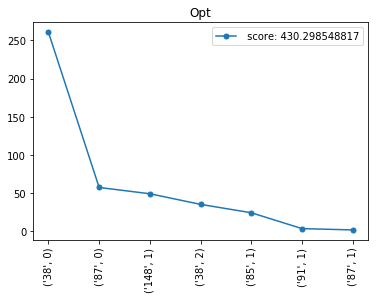

In [16]:
opt_cluster = [(l,p) for (l,p) in scores.optimized_scores.items()]
#print opt_cluster
opt_cluster = {(l,p):xglides[l][struct].poses[p].fp for (l,p) in opt_cluster}
#print opt_cluster
get_ipython().magic(u'matplotlib inline')
plot_shared_interactions(opt_cluster, max_r=20,title='Opt')

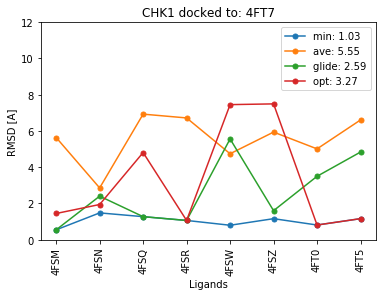

In [17]:
final_rmsds = plot_final_rmsds(scores, receptor+' docked to: '+'4FT7')

In [19]:
#get_ipython().magic(u'matplotlib inline')
#for l in lig_subset:
#    top_p = int(np.argmax(scores.get_final_scores(l)[:-1]))
#    plot_shared_interactions(scores.get_neighbor_cluster(l,top_p), max_r=20, title=l)
    

In [ ]:
three_ligs = ['4FSM','4FSN','4FSQ']
(l1,l2,l3) = tuple(three_ligs)
struct = '4FT7'

pairs = [('4FSM', '4FSN'), ('4FSQ','4FSM'), ('4FSM','4FSR'),('4FSW','4FSZ'),('4FSW','4FT0'),('4FT5','4FSN')]

In [ ]:
get_ipython().magic(u'matplotlib inline')
for (l1, l2) in pairs:
    scores1 = Scores(xglides, xcrystals, [l1,l2], struct, n, distance)
    scores2 = Scores(xglides, xcrystals, [l1,l2], struct, n, mul_overlap)
    scores3 = Scores(xglides, xcrystals, [l1,l2], struct, n, add_overlap)
    #scores4 = Scores(xglides, xcrystals, [l1,l2], struct, n, pair_score)
    plot_all_poses(l1, l2, scores1, '{},{},{}'.format(l1, l2, 'l1-dist'))
    plot_all_poses(l1, l2, scores2, '{},{},{}'.format(l1, l2, 'mult'))
    plot_all_poses(l1, l2, scores3, '{},{},{}'.format(l1, l2, 'add'))
    #plot_all_poses(l1, l2, scores4, '{},{},{}'.format(l1, l2, 'mul-dist'))
    
    plot_ifp_comparison(xcrystals[l1].fp, xcrystals[l2].fp, lab1=l1, lab2=l2)

In [ ]:
get_ipython().magic(u'matplotlib inline')

(l1_b, l1_t) = 3, 13
(l2_b, l2_t) = 5, 11
(l3_b, l3_t) = 3, 19

fp1 = xglides[l1][struct].poses[l1_b].fp
fp2 = xglides[l2][struct].poses[l2_b].fp
fp3 = xglides[l3][struct].poses[l3_b].fp

lab1 = l1 + ' Best'
lab2 = l2 + ' Best'
lab3 = l3 + ' Best'

plot_ifp_comparison(fp1, fp2, i=[0,1,3], lab1=lab1, lab2=lab2)
plot_ifp_comparison(fp1, fp3, i=[0,1,3], lab1=lab1, lab2=lab3)
plot_ifp_comparison(fp2, fp3, i=[0,1,3], lab1=lab2, lab2=lab3)

In [ ]:
fp4 = xglides[l1][struct].poses[l1_t].fp
fp5 = xglides[l2][struct].poses[l2_t].fp
fp6 = xglides[l3][struct].poses[l3_t].fp

lab4 = l1 + ' Top'
lab5 = l2 + ' Top'
lab6 = l3 + ' Top'

plot_ifp_comparison(fp4, fp5, i=[0,1,3], lab1=lab4, lab2=lab5)
plot_ifp_comparison(fp4, fp6, i=[0,1,3], lab1=lab4, lab2=lab6)
plot_ifp_comparison(fp5, fp6, i=[0,1,3], lab1=lab5, lab2=lab6)

In [ ]:
pose_ind = [(-1,-1,-1)]
x = [0]
y1 = [list_add_overlap([xcrystals[l1].fp, xcrystals[l2].fp, xcrystals[l3].fp])]
y2 = [list_distance([xcrystals[l1].fp, xcrystals[l2].fp, xcrystals[l3].fp])]
for p1 in range(n):
    print p1
    f1 = xglides[l1][struct].poses[p1]
    for p2 in range(n):
        f2 = xglides[l2][struct].poses[p2]
        for p3 in range(n):
            pose_ind.append((p1, p2, p3))
            f3 = xglides[l3][struct].poses[p3]
            x.append((f1.rmsd+f2.rmsd+f3.rmsd)/3)
            y1.append(list_add_overlap([f1.fp, f2.fp, f3.fp]))
            y2.append(list_distance([f1.fp, f2.fp, f3.fp]))
#top_sum = int(np.argmax(y_sum[1:]) + 1)
#(p1_s, p2_s, p3_s) = pose_ind[top_sum]
#top_mul = int(np.argmax(y_mul[1:]) + 1)
#(p1_m, p2_m, p3_m) = pose_ind[top_mul]
#print 'Sum Objective RMSD: {}, Score: {}'.format(x[top_sum], y_sum[top_sum])
#print 'Top triplet: {}: {}. {}: {}. {}:{}.'.format(l1, p1_s, l2, p2_s, l3, p3_s)
#print 'Mul Objective RMSD: {}, Score: {}'.format(x[top_mul], y_mul[top_mul])
#print 'Top triplet: {}: {}. {}: {}. {}:{}.'.format(l1, p1_m, l2, p2_m, l3, p3_m)
plt.plot(x, y1, '.')
plt.title('Add Objective: ' + struct)
plt.show()
plt.plot(x, y2, '.')
plt.title('Dist Objective: ' + struct)
plt.show()
#f_list_mul = [xglides[l1][struct].poses[p1_m].fp, xglides[l2][struct].poses[p2_m].fp, xglides[l3][struct].poses[p3_m].fp]
#f_list_sum = [xglides[l1][struct].poses[p1_s].fp, xglides[l2][struct].poses[p2_s].fp, xglides[l3][struct].poses[p3_s].fp]

#three_crystals = [xcrystals[l1].fp, xcrystals[l2].fp, xcrystals[l3].fp]
#plot_fp_breakdown(three_crystals + [overlap(three_crystals[0], three_crystals[1]),
#                  overlap(three_crystals[0], three_crystals[2]),
#                  overlap(three_crystals[1], three_crystals[2]),
#                  overlap(overlap(three_crystals[0], three_crystals[1]), three_crystals[2])],
#                  [l1, l2, l3, l1+l2, l1+l3, l2+l3, 'all'], 'Crystal Cluster. RMSD: 0')

#plot_fp_breakdown(f_list_mul + [overlap(f_list_mul[0], f_list_mul[1]),
#                  overlap(f_list_mul[0], f_list_mul[2]),
#                  overlap(f_list_mul[1], f_list_mul[2]),
#                  overlap(overlap(f_list_mul[0], f_list_mul[1]), f_list_mul[2])],
#                  [l1, l2, l3, l1+l2, l1+l3, l2+l3, 'all'], 'Top Mul Cluster. RMSD: {}'.format(x[top_mul]))

#plot_fp_breakdown(f_list_sum + [overlap(f_list_sum[0], f_list_sum[1]),
#                  overlap(f_list_sum[0], f_list_sum[2]),
#                  overlap(f_list_sum[1], f_list_sum[2]),
#                  overlap(overlap(f_list_sum[0], f_list_sum[1]), f_list_sum[2])],
#                  [l1, l2, l3, l1+l2, l1+l3, l2+l3, 'all'], 'Top Sum Cluster. RMSD: {}'.format(x[top_sum]))
    
#print 'average across all data:'
#print_table(all_final)

In [ ]:
for combo in range(10):
    combo_obj = np.subtract(y1, np.multiply(combo*10,y2))
    top_obj = int(np.argmax(combo_obj[1:]) + 1)
    print '{}, Top RMSD: {}, Score: {}'.format(combo, x[top_obj], combo_obj[top_obj])
    
    (p1_s, p2_s, p3_s) = pose_ind[top_obj]
    print 'Top triplet: {}: {}. {}: {}. {}:{}.'.format(l1, p1_s, l2, p2_s, l3, p3_s)
    
    plt.plot(x, combo_obj, '.')
    plt.title(combo)
    plt.show()

In [ ]:
def pair_score(fp1, fp2, i=None):
    return mul_overlap(fp1, fp2) - 20*distance(fp1, fp2, 1)

def list_add_overlap(fp_list):
    res_intersect = set([r for i in fp_list for r in i.feats.keys()])
    new_feats = {}
    score = 0
    for r in res_intersect:
        for fp in fp_list:
            new_feats[r] = np.add(new_feats.get(r, [0,0,0,0,0]), np.square(fp.feats.get(r,[0,0,0,0,0])))
        #new_feats[r] = np.add(fp1.feats[r], fp2.feats.get(r,[0,0,0,0,0]))
        score += np.sum(np.square(new_feats[r]))
    return score
    
def list_distance(fp_list, p=1):
    score = 0
    for i in range(len(fp_list)):
        for j in range(i+1, len(fp_list)):
            score += distance(fp_list[i], fp_list[j], p)
    return score

def objective(fp_list, p=1, scale=1):
    return list_add_overlap(fp_list) - scale*list_distance(fp_list, p)

In [ ]:
get_ipython().magic(u'matplotlib inline')

all_final = {}

good_ligs = three_ligs#['4FSM','4FSN','4FSQ']#,'4FT0']
#[l for l in all_ligs if best_rmsd_matrix[all_structs.index(struct)][all_ligs.index(l)] < 1.5]
# all_ligs = ['4FSM', '4FSN', '4FSQ', '4FSR', '4FSW', '4FSZ', '4FT0', '4FT5']
#if False in good_poses: 
#    print 'no good poses found for some ligands! proceed with caution...'

scores = Scores(xglides, xcrystals, good_ligs, struct, n, pair_score)
final_rmsds = plot_final_rmsds(scores, receptor+' docked to: '+struct)

#plot_all_pairs(l1,l2,l3,scores)

# print out our performance
a = scores.all_analysis
print_table({i:a[i][1][:] for i in a})

analyze(scores)